# Inversion with automatic differentation

_The forward problem:_ We know the source function $f(t)$ and the properties of the rock medium where the seismic wave propagates $\rho$ and $V_S$. We want to model numerically the waveforms of the seismograms that will be observed at the receivers.

For that, we solve the seismic wave equation (here in 1D):

$\rho \frac{\partial v}{\partial t} = \frac{\partial s}{\partial x} + f(x)$ and $\frac{\partial s}{\partial t} = \mu \frac{\partial v}{\partial x}$

where $v$ is the velocity, $s$ is the stress, $x$ is the direction of propagation, $t$ is the time, and $\mu = \rho V_S^2$ is the shear modulus.

_The inverse problem:_ We know the source function $f(t)$ and the seismograms at some receivers $d(x_{ir}, t)$ for some $x_{ir}$ with $ir = 1 , \cdots , nr$. We want to guess what are the values of $\rho$ and $V_S$.

For that, we define a loss function:

$J = \frac{1}{2} \sum_{ir = 1}^{nr} \sum_{it = 1}^{nt} (v(x_{ir}, t) - d(x_{ir}, t))^2$

At the beginning, we choose initial values $\rho_0$ and $V_{S 0}$ and we compute the corresponding values of the velocity $v(x_{ir}, t)$ using forward modeling. We compute the corresponding value of the loss function, and the gradient of the loss function with respect to the rock properties $\frac{\partial J}{\partial \rho}$ and $\frac{\partial J}{\partial \mu}$. We use the gradient descent method to update the values of $\rho$ and $V_S$ and we continue until the loss $J(\rho, V_S)$ is small enough.

As we mainly need to compute a gradient, we can use automatic differentiation and PyTorch to do that.

Import Python modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from math import pi
from scipy.signal import butter, lfilter

Define the properties of the model.

In [2]:
# Size of the model
N = 200
dx = 100.0
dt = 0.01
T = 400
# Rock properties
rho = 2500.0
# Source
f = np.sin(2 * pi * np.arange(start=0, step=dt, stop=1 + dt))
x0 = 81
# Receivers
x = [91, 101, 111, 121]

We are going to compute synthetics seismograms. Here is the function to do forward modeling:

In [3]:
def forward(N, dx, T, dt, rho, mu, f, x0, x):
    # Initialization
    obs = np.zeros((T, len(x)))
    v = np.zeros(N + 3)
    s = np.zeros(N + 4)
    # Loop on time
    for i in range(0, T):
        # Compute stress
        ds = 1.0e10 * mu[2 : (N + 2)] * ((9.0 / 8.0) * (v[2 : (N + 2)] - v[1 : (N + 1)]) - \
                                        (1.0 / 24.0) * (v[3 : (N + 3)] - v[0 : N])) / dx
        s[2 : (N + 2)] = s[2 : (N + 2)] + ds * dt
        # Boundary condition (reflection)
        s[1] = - s[2]
        s[0] = - s[3]
        s[N + 2] = - s[N + 1]
        s[N + 3] = - s[N]
        # Compute velocity
        dv = (1.0 / rho) * ((9.0 / 8.0) * (s[2 : (N + 3)] - s[1 : (N + 2)]) - \
                           (1.0 / 24.0) * (s[3 : (N + 4)] - s[0 : (N + 1)])) / dx
        v[1 : (N + 2)] = v[1 : (N + 2)] + dv * dt
        # Add force
        if i < len(f):
            v[x0] = v[x0] + f[i]
        # Receivers
        for j in range(0, len(x)):
            obs[i, j] = v[x[j]]
    return obs

We choose a velocity model.

In [4]:
vs1 = 2000.0
vs2 = 1800.0
mu = np.concatenate([np.repeat(1.0, N - 93), np.repeat(0.81, 97)])

We run the forward simulation for this velocity model.

In [5]:
d = forward(N, dx, T, dt, rho, mu, f, x0, x)

We filter and plot the synthetics.

In [6]:
b, a = butter(4, 0.1, btype='low')

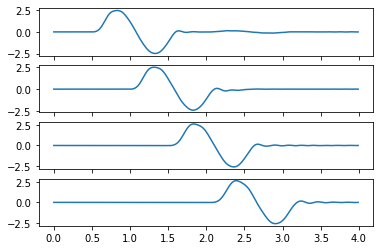

In [7]:
ax1 = plt.subplot(411)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 0]))
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(412)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 1]))
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(413)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 2]))
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(414)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 3]))

## Using automatic differentiation

The forward modeling is done as we have done to create the synthetic seismograms. The only difference is that we use PyTorch tensors instead of Numpy arrays, in order to be able to compute the gradient using automatic differentation.

In [8]:
def forward_AD(N, dx, T, dt, rho, mu, f, x0, x):
    # Initialization
    obs = torch.zeros((T, len(x)))
    v = torch.zeros(N + 3)
    s = torch.zeros(N + 4)
    # Loop on time
    for i in range(0, T):
        # Compute stress
        ds = 1.0e10 * mu[2 : (N + 2)] * ((9.0 / 8.0) * (v[2 : (N + 2)] - v[1 : (N + 1)]) - \
                                        (1.0 / 24.0) * (v[3 : (N + 3)] - v[0 : N])) / dx
        s[2 : (N + 2)] = s[2 : (N + 2)] + ds * dt
        # Boundary condition (reflection)
        s[1] = - s[2]
        s[0] = - s[3]
        s[N + 2] = - s[N + 1]
        s[N + 3] = - s[N]
        # Compute velocity
        dv = (1.0 / rho) * ((9.0 / 8.0) * (s[2 : (N + 3)] - s[1 : (N + 2)]) - \
                           (1.0 / 24.0) * (s[3 : (N + 4)] - s[0 : (N + 1)])) / dx
        v[1 : (N + 2)] = v[1 : (N + 2)] + dv * dt
        # Add force
        if i < len(f):
            v[x0] = v[x0] + f[i]
        # Receivers
        for j in range(0, len(x)):
            obs[i, j] = v[x[j]]
    return obs

The loss is also computed with PyTorch tensors instead of Numpy arrays.

In [9]:
def loss_AD(obs, d):
    F = 0
    for j in range(0, obs.size()[1]):
        F = F + torch.sum(torch.square(obs[:, j] - torch.from_numpy(d[:, j]))) / 2
    return F

At each step of the optimization process, we compute the current value of the loss, then the gradient of the loss with respect to the value of the shear module $\mu$, and we update the value of $\mu$.

In [10]:
def step(N, dx, T, dt, rho, mu, f, x0, x, d, alpha):
    # Compute the loss for the current value of mu
    obs = forward_AD(N, dx, T, dt, rho, mu, f, x0, x)
    F = loss_AD(obs, d)
    # Compute the gradient of the loss
    F.backward()
    # Specifically, we want the gradient with respect to mu
    dmu = mu.grad
    # Update the values of mu
    mu = mu - alpha * dmu
    mu.retain_grad()
    # Return the new value of mu
    return (mu, F)

We can now write the optimization function. At each step, we save the current value of mu and the value of the loss. We must choose the value of the learning rate $\alpha$.

In [11]:
def invert_mu(N, dx, T, dt, rho, f, x0, x, d, alpha, n_epochs):
    save_mu = np.zeros((N + 3, n_epochs))
    save_F = np.zeros(n_epochs)
    f = torch.from_numpy(f)
    mu = torch.from_numpy(np.repeat(1.0, N + 3))
    mu.requires_grad = True
    for epoch in range(0, n_epochs):
        (mu, F) = step(N, dx, T, dt, rho, mu, f, x0, x, d, alpha)
        save_mu[:, epoch] = mu.detach().numpy()
        save_F[epoch] = F
    return (mu, save_mu, save_F)

We can now run the optimization algorithm.

In [12]:
(mu, save_mu, save_F) = invert_mu(N, dx, T, dt, rho, f, x0, x, d, 0.001, 20)

Let us first plot the evolution of the loss.

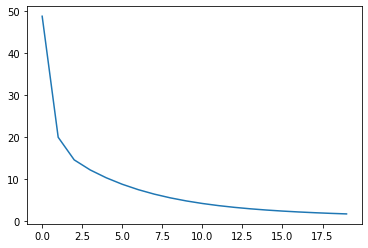

In [13]:
plt.plot(np.arange(0, 20), save_F)

We can also plot the seismograms computed with the last value of $\mu$ and compare it the true value of the synthetics.

In [14]:
obs = forward_AD(N, dx, T, dt, rho, mu, f, x0, x)

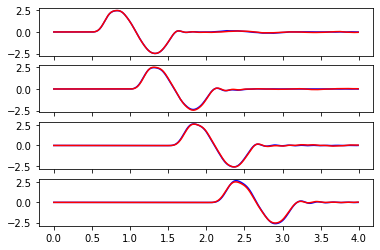

In [15]:
ax1 = plt.subplot(411)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 0]), 'b')
plt.plot(dt * np.arange(0, T), lfilter(b, a, obs.detach().numpy()[:, 0]), 'r')
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(412)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 1]), 'b')
plt.plot(dt * np.arange(0, T), lfilter(b, a, obs.detach().numpy()[:, 1]), 'r')
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(413)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 2]), 'b')
plt.plot(dt * np.arange(0, T), lfilter(b, a, obs.detach().numpy()[:, 2]), 'r')
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(414)
plt.plot(dt * np.arange(0, T), lfilter(b, a, d[:, 3]), 'b')
plt.plot(dt * np.arange(0, T), lfilter(b, a, obs.detach().numpy()[:, 3]), 'r')

We can see that there is a good agreement between the theoretical seismograms and the obtained after the inversion. Let us now look at the value of $\mu$.

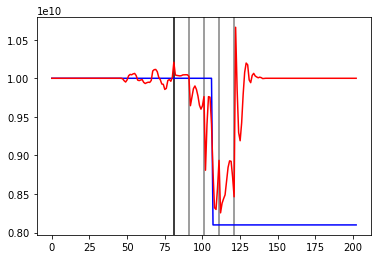

In [16]:
plt.axvline(x0, color='black')
for j in range(0, len(x)):
    plt.axvline(x[j], color='grey')
plt.plot(np.arange(0, N + 3), np.concatenate([np.repeat(rho * vs1 * vs1, N - 93), np.repeat(rho * vs2 * vs2, 96)]), 'b')
plt.plot(np.arange(0, N + 3), 1.0e10 * mu.detach().numpy(), 'r')